<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snow_melt_prediction_with_TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -U keras-tuner
# !pip install keras==2.12.0
# !pip install scikeras
# !pip install keras-tcn

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt

# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [21]:

# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab Notebooks/dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)

df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


In [22]:
# features = ['Date',"Q","SCA","T",'P']
features = ['Date',"Q","SCA","T"]
# features = ["Q"]
df_snow_melting = df_snow_melting[features]

In [23]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)
df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


<ipython-input-23-6a192a8b458d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


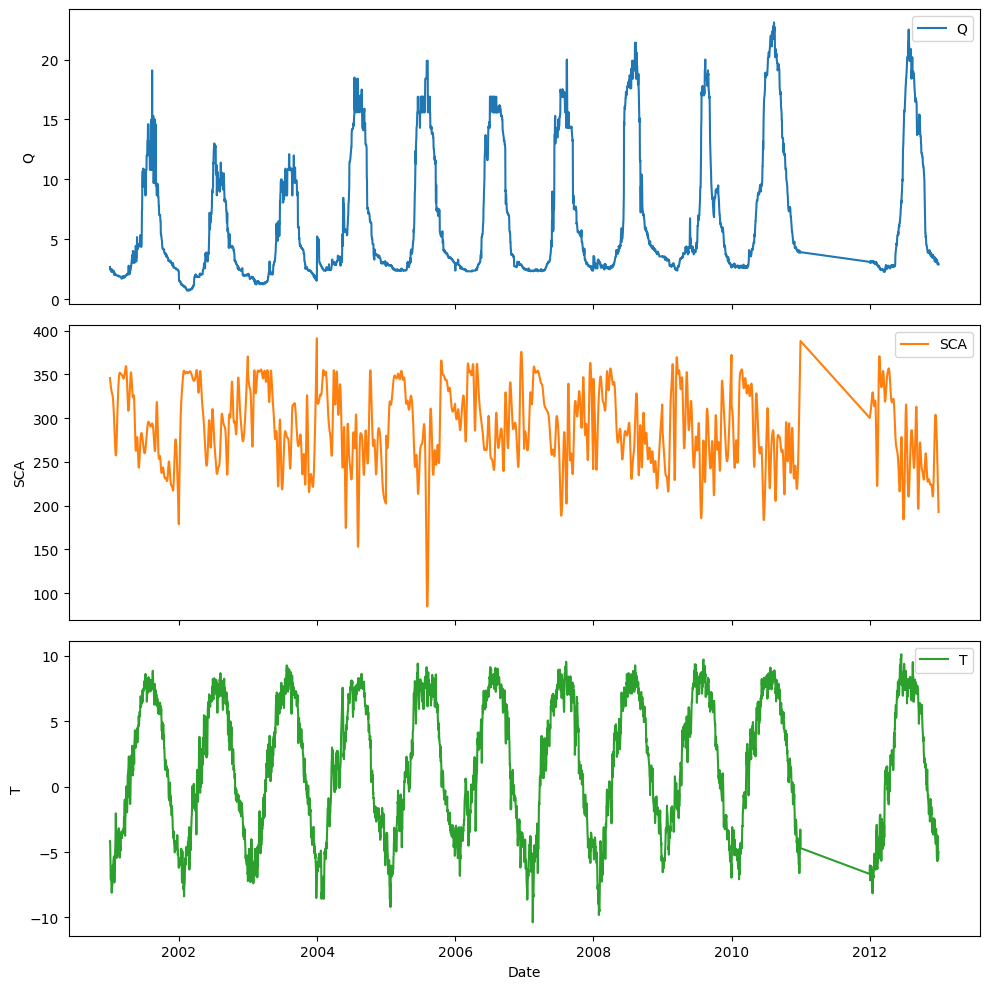

In [24]:
features = ["Q","SCA","T"]
# Create subplots for each column
fig, axes = plt.subplots(len(features), 1, figsize=(10, 10), sharex=True)

for i, column in enumerate(features):
    axes[i].plot(df_snow_melting['Date'], df_snow_melting[column], label=column, color='C'+str(i))
    axes[i].set_ylabel(column)
    axes[i].legend()

# Set common x-label
axes[-1].set_xlabel('Date')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [25]:
# Normalize

df_input = df_snow_melting[features]


scaler = StandardScaler()

# Select the features you want to scale
features_to_scale = ['Q', 'SCA', 'T']

# Fit the scaler to the data and transform the selected features
df_input[features_to_scale] = scaler.fit_transform(df_input[features_to_scale])


<ipython-input-25-ed95cad648f8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[features_to_scale] = scaler.fit_transform(df_input[features_to_scale])


In [26]:
df_input = df_input[features_to_scale]
df_input

,Q,SCA,T
0,-0.714983,1.306925,-1.170123
1,-0.744452,1.255788,-1.164703
2,-0.744452,1.205464,-1.365690
3,-0.762871,1.156767,-1.640360
4,-0.744452,1.110509,-1.707563
...,...,...,...
4012,-0.674462,-1.409374,-1.466072
4013,-0.674462,-1.626085,-1.436107
4014,-0.652360,-1.839801,-1.441230
4015,-0.663411,-2.047526,-1.357451


In [27]:

def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(df_input,WINDOW_SIZE)

X.shape, y.shape

((4015, 2, 3), (4015,))

In [28]:
X

array([[[-0.71498271,  1.30692466, -1.17012327],
        [-0.74445237,  1.25578792, -1.16470256]],

       [[-0.74445237,  1.25578792, -1.16470256],
        [-0.74445237,  1.20546435, -1.36568973]],

       [[-0.74445237,  1.20546435, -1.36568973],
        [-0.76287091,  1.15676709, -1.64035988]],

       ...,

       [[-0.67446192, -1.40937354, -1.46607233],
        [-0.67446192, -1.6260851 , -1.43610668]],

       [[-0.67446192, -1.6260851 , -1.43610668],
        [-0.65235967, -1.83980116, -1.44123046]],

       [[-0.65235967, -1.83980116, -1.44123046],
        [-0.6634108 , -2.04752622, -1.35745124]]])

In [29]:
y

array([-0.74445237, -0.76287091, -0.74445237, ..., -0.65235967,
       -0.6634108 , -0.67446192])

In [117]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle = False,random_state=42)
X_val,X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle = False,random_state=42)

In [118]:
X_train.shape


(3212, 2, 3)

In [119]:
# Reshape the input data to match the expected shape
X_train_new = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_train_new.shape[1:]

(2, 3)

In [123]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tcn import TCN  # You'll need to install the 'tcn' library

# Assuming you have your time series data in X_train and corresponding target values in Y_train

# Define the TCN regression model
def create_tcn_regression_model(input_shape):
    input_layer = Input(shape=input_shape)
    tcn_layer = TCN(nb_filters=64, kernel_size=2, dilations=[1, 2, 4, 8], return_sequences=True)(input_layer)
    tcn_layer = TCN(nb_filters=64, kernel_size=2, dilations=[1, 2, 4, 8], return_sequences=True)(input_layer)
    tcn_layer = TCN(nb_filters=64, kernel_size=2, dilations=[1, 2, 4, 8], return_sequences=False)(input_layer)
    output_layer = Dense(1, activation='linear')(tcn_layer)  # Output layer for regression
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# Define the input shape based on your data
input_shape = X_train.shape[1:]

# Create the TCN regression model
model = create_tcn_regression_model(input_shape)

# Compile the model
Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer='adam', loss='mean_squared_error')  # Use 'mean_squared_error' for regression

# # Train the model on your data
# model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)  # Adjust validation split as needed


In [124]:
cp = ModelCheckpoint('model1/',save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss",
                               patience = 10,
                               mode = 'min')

model.fit(X_train,y_train,batch_size=32,validation_data=(X_val,y_val),epochs=100,callbacks=[cp,early_stopping])

Epoch 1/100
101/101 [==============================] - 4s 24ms/step - loss: 0.1730 - val_loss: 0.0161
Epoch 2/100
101/101 [==============================] - 2s 22ms/step - loss: 0.0164 - val_loss: 0.0110
Epoch 3/100
101/101 [==============================] - 0s 5ms/step - loss: 0.0158 - val_loss: 0.0115
Epoch 4/100
101/101 [==============================] - 0s 4ms/step - loss: 0.0166 - val_loss: 0.0119
Epoch 5/100
101/101 [==============================] - 1s 5ms/step - loss: 0.0157 - val_loss: 0.0162
Epoch 6/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0174 - val_loss: 0.0146
Epoch 7/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0146 - val_loss: 0.0155
Epoch 8/100
101/101 [==============================] - 1s 7ms/step - loss: 0.0158 - val_loss: 0.0119
Epoch 9/100
101/101 [==============================] - 3s 33ms/step - loss: 0.0154 - val_loss: 0.0103
Epoch 10/100
101/101 [==============================] - 0s 5ms/step - loss: 0.0138 - val

101/101 [==============================] - 0s 2ms/step
MAE: 0.052516991138539276
RMSE: 0.09728499104594251
R-squared (R2): 0.9891180020272798


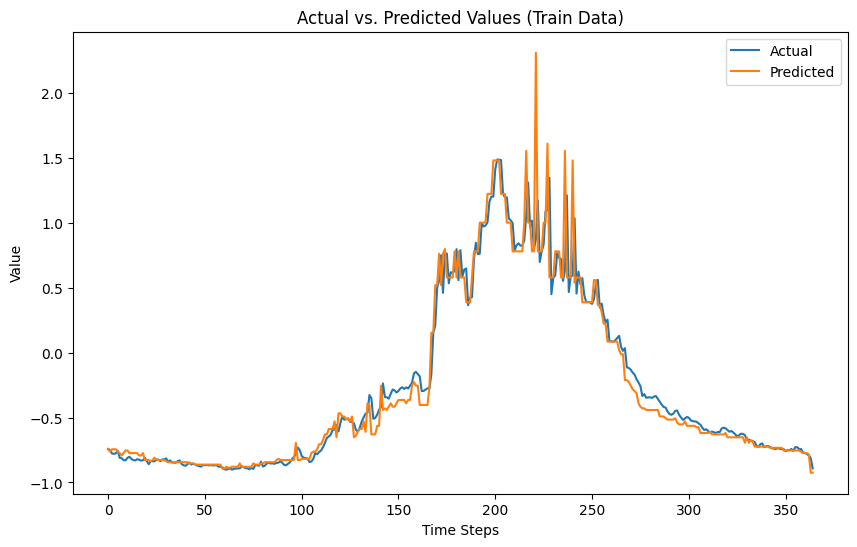

In [125]:
train_predictions = model.predict(X_train).flatten()
# train_predictions.shape
train_result = pd.DataFrame(data={"Train Predictions":train_predictions,"Actuals":y_train})
# Calculate MAE
mae = mean_absolute_error(y_train, train_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

# Calculate R2
r2 = r2_score(y_train, train_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)



plt.figure(figsize=(10, 6))
plt.plot(train_result['Train Predictions'][0:365], label='Actual')
plt.plot(train_result['Actuals'][0:365], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Train Data)')
plt.legend()
plt.show()

13/13 [==============================] - 0s 2ms/step
MAE: 0.055807090117570096
RMSE: 0.08162441233565479
R-squared (R2): 0.9955992162165989


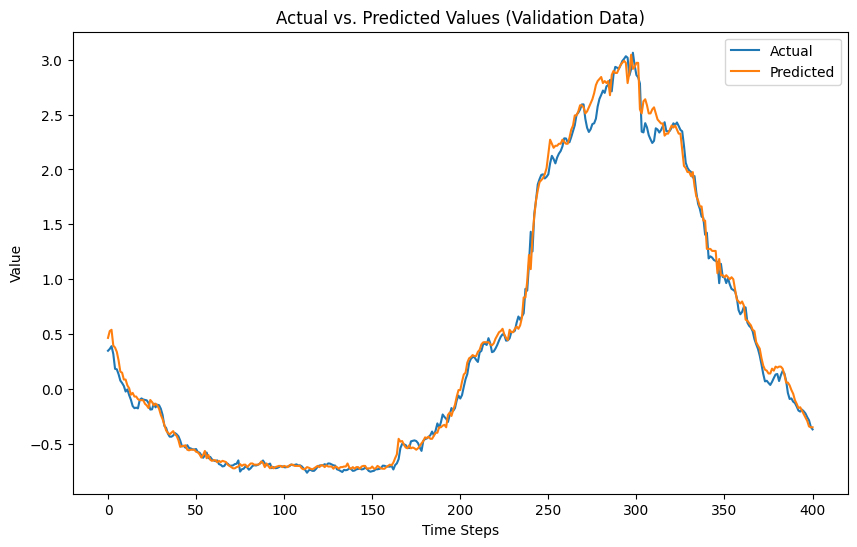

In [126]:
val_predictions = model.predict(X_val).flatten()


# Calculate MAE
mae = mean_absolute_error(y_val, val_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

# Calculate R2
r2 = r2_score(y_val, val_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)


val_result = pd.DataFrame(data={"val Predictions":val_predictions,"Actuals":y_val})


plt.figure(figsize=(10, 6))
plt.plot(val_result['val Predictions'], label='Actual')
plt.plot(val_result['Actuals'], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Validation Data)')
plt.legend()
plt.show()

13/13 [==============================] - 0s 2ms/step
MAE: 0.05464945608691707
RMSE: 0.08239935502159733
R-squared (R2): 0.9945982698506667


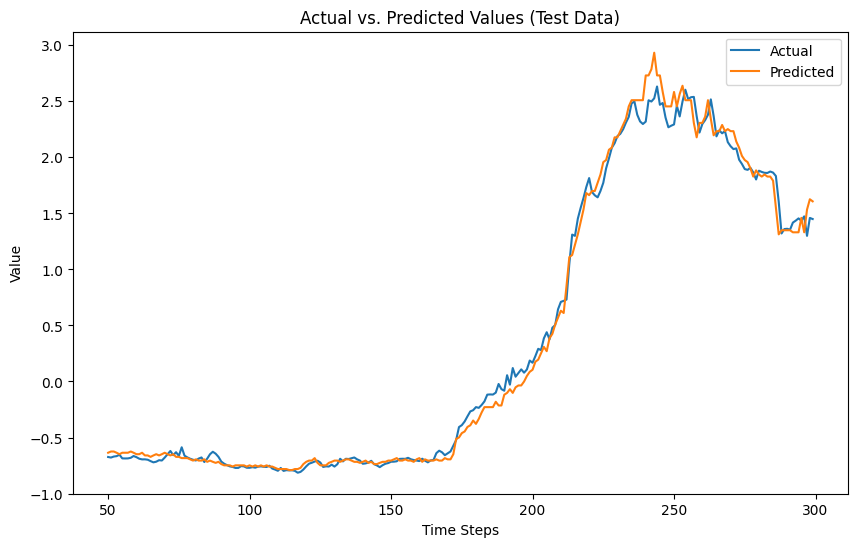

In [127]:
test_predictions = model.predict(X_test).flatten()

# Calculate MAE
mae = mean_absolute_error(y_test, test_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Calculate R2
r2 = r2_score(y_test, test_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)


test_result = pd.DataFrame(data={"test Predictions":test_predictions,"Actuals":y_test})

plt.figure(figsize=(10, 6))
plt.plot(test_result['test Predictions'][50:300], label='Actual')
plt.plot(test_result['Actuals'][50:300], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()

In [128]:
from sklearn.model_selection import KFold, ParameterGrid
nested_scores = []
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Nested Cross-Validation
for train_ix, test_ix in outer_cv.split(X):
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]


    # Now that we have the best model, evaluate it on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    nested_scores.append({
        "MSE": mse,
        "R^2": r2,
        "RMSE": rmse,
        "MAE": mae
    })

# Calculate overall statistics
mean_mse = np.mean([scores['MSE'] for scores in nested_scores])
mean_r2 = np.mean([scores['R^2'] for scores in nested_scores])
mean_rmse = np.mean([scores['RMSE'] for scores in nested_scores])
mean_mae = np.mean([scores['MAE'] for scores in nested_scores])

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean RMSE: {mean_rmse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")



26/26 [==============================] - 0s 2ms/step
Mean MSE: 0.009
Mean R^2: 0.991
Mean RMSE: 0.094
Mean MAE: 0.053


In [129]:

for fold, scores in enumerate(nested_scores):
    print(f"Fold {fold + 1} - MSE: {scores['MSE']:.3f}, MAE: {scores['MAE']:.3f},RMSE: {scores['RMSE']:.3f}, R^2: {scores['R^2']:.3f}")


Fold 1 - MSE: 0.011, MAE: 0.055,RMSE: 0.105, R^2: 0.989
Fold 2 - MSE: 0.009, MAE: 0.053,RMSE: 0.093, R^2: 0.991
Fold 3 - MSE: 0.009, MAE: 0.055,RMSE: 0.094, R^2: 0.991
Fold 4 - MSE: 0.009, MAE: 0.053,RMSE: 0.097, R^2: 0.991
Fold 5 - MSE: 0.007, MAE: 0.049,RMSE: 0.082, R^2: 0.993


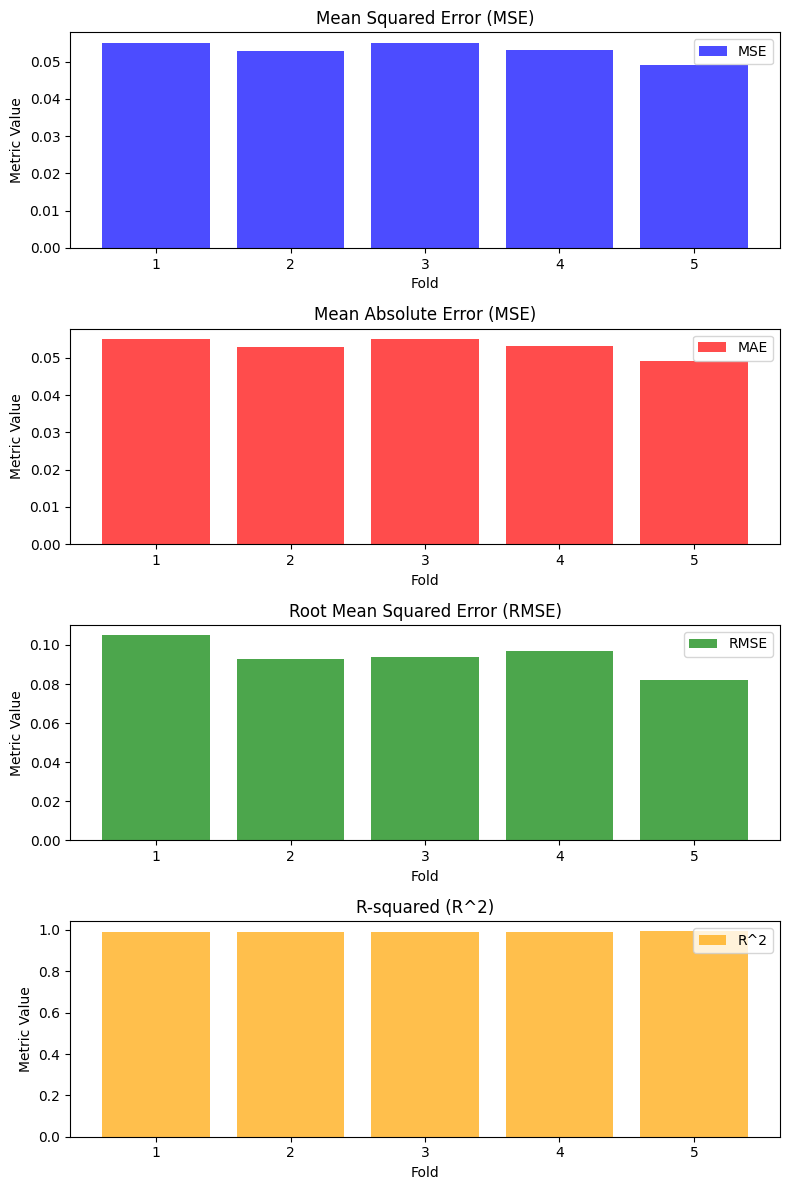

In [130]:
import matplotlib.pyplot as plt

# Extract the metrics from the nested_scores list
fold_numbers = range(1, len(nested_scores) + 1)
mse_values = [score['MSE'] for score in nested_scores]
mse_values = [score['MAE'] for score in nested_scores]
rmse_values = [score['RMSE'] for score in nested_scores]
r2_values = [score['R^2'] for score in nested_scores]

# Create subplots for each metric
fig, axs = plt.subplots(4, figsize=(8, 12))

# Create bar plots for each metric
axs[0].bar(fold_numbers, mse_values, color='blue', alpha=0.7, label='MSE')
axs[0].set_title('Mean Squared Error (MSE)')

axs[1].bar(fold_numbers, mse_values, color='red', alpha=0.7, label='MAE')
axs[1].set_title('Mean Absolute Error (MSE)')

axs[2].bar(fold_numbers, rmse_values, color='green', alpha=0.7, label='RMSE')
axs[2].set_title('Root Mean Squared Error (RMSE)')

axs[3].bar(fold_numbers, r2_values, color='orange', alpha=0.7, label='R^2')
axs[3].set_title('R-squared (R^2)')

# Add labels and legends
for ax in axs:
    ax.set_xlabel('Fold')
    ax.set_ylabel('Metric Value')
    ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [132]:
import joblib
joblib.dump(model, '/content/drive/MyDrive/Colab Notebooks/model/tcn_model_inout_3.pkl')

['/content/drive/MyDrive/Colab Notebooks/model/tcn_model_inout_3.pkl']